In [22]:
# importing all necessary packages
import numpy as np
import pandas as pd
import re
import itertools
import math
import ast

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics.pairwise import euclidean_distances

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# My Workflow

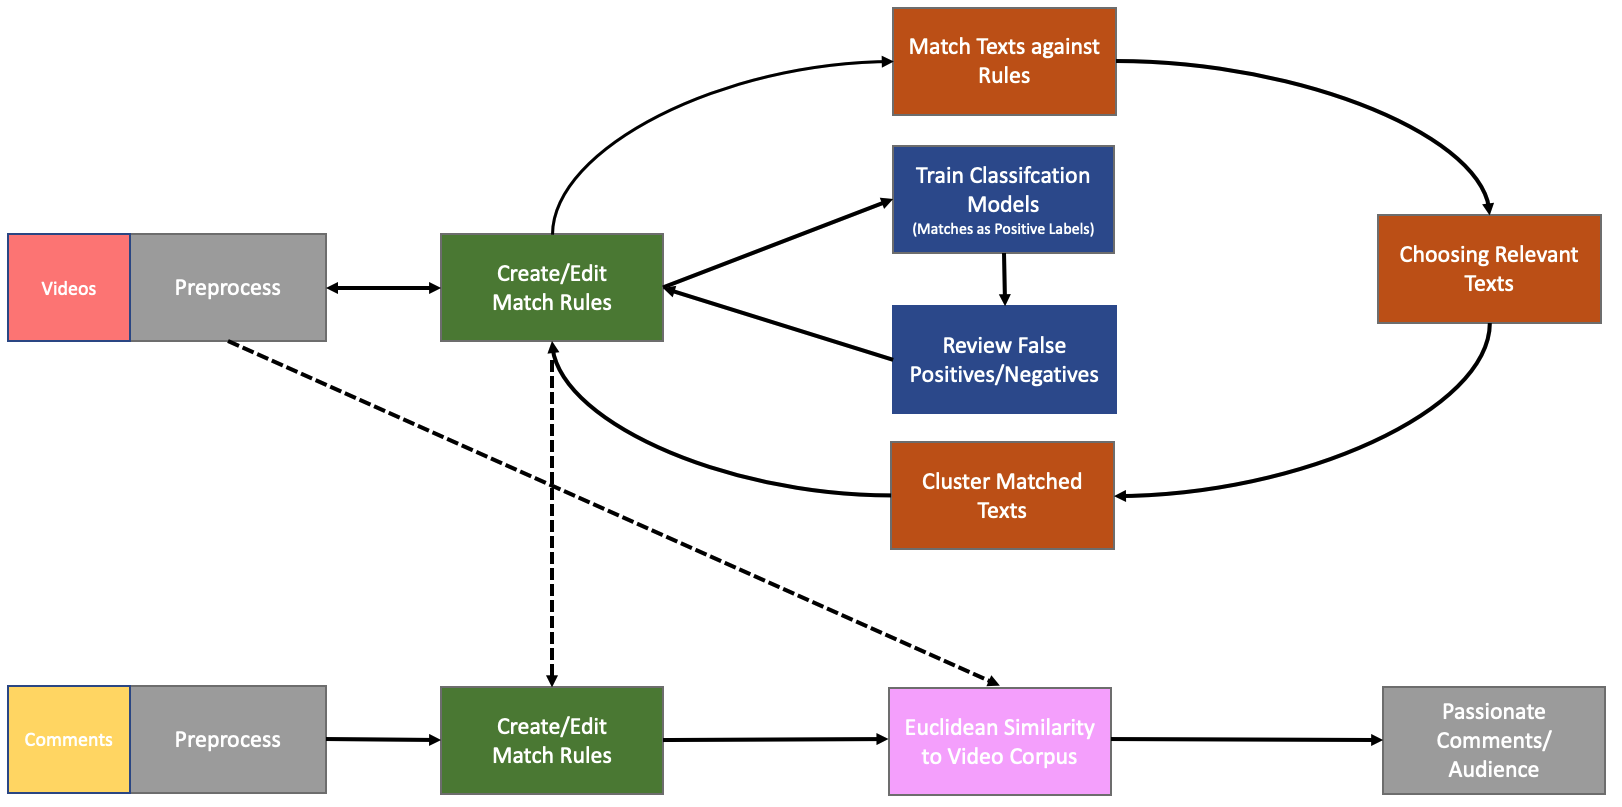

In [25]:
Image(filename='workflow.png', width = 1500, height = 400)

# 1. Imports

In [2]:
# loading datasets
comments = pd.read_csv('video_comments.csv')
descriptions = pd.read_csv('video_descriptions.csv', engine='python')

# 2. Proprocessing and Normalizing Functions

In [144]:
# functions to preprocess the text
CONTRACTION_MAP = {"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"}

# expanding the contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower()) 
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text) 
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# normalizing text (removing links), special characters, and expanding contractions
def normalize(s):
    s = str(s)
    stripped = re.sub('http://\S+|https://\S+', '', s)
    stripped = re.sub(r'[^a-zA-z0-9\s]' , '', stripped)
    stripped = re.sub('\n','',stripped)
    stripped = re.sub('_','',stripped)
    stripped = re.sub('-','',stripped)
    stripped = stripped.lower()
    stripped = stripped.strip("[]")
    stripped = expand_contractions(stripped)
    return stripped

# creating a set of stop words. more stop words are updated for these datasets
stop_words = set(stopwords.words('english'))
extra_words = ["[","]",'copyright','1','2','3','4','5','us','tumblr','patreon','twitter', 'facebook', 'creepypasta', 'instagram', 'like', 'video','subscribe', 'please', 'channel', 'comment', 'forget',  'check',   'thanks',  'guys',    'enjoy',   'share',   'follow', 'plea', 'watching', "'", "'d", "'ll", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'r', 'sha', 'themselv', 'thi', 'v', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv','becau', 'guy', 'pleas', 'subscrib', 'thank', 'watch']
for w in extra_words:
    stop_words.add(w)

# preprocessing text: normalizing and then tokenizing
def preprocess(text):
    preprocessed = normalize(text)
    tokens = word_tokenize(preprocessed)
    filtered_tokens = [token for token in tokens if token not in stop_words_2]
    return filtered_tokens

# 3. Finding Ghostbusters Related Videos

## 3.1 Video/Descriptions Dataset Cleaning

In [4]:
# getting info of description df
descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38521 entries, 0 to 38520
Data columns (total 9 columns):
Video ID           38521 non-null object
Video Title        38521 non-null object
tag                36191 non-null object
Description        37931 non-null object
Video Post Date    38521 non-null object
Video Owner ID     38521 non-null object
No. of Comments    36338 non-null float64
No. of Likes       36207 non-null float64
No. of Dislikes    36207 non-null float64
dtypes: float64(3), object(6)
memory usage: 2.6+ MB


In [5]:
# columns and ...
descriptions.columns

Index(['Video ID', 'Video Title', 'tag', 'Description', 'Video Post Date',
       'Video Owner ID', 'No. of Comments', 'No. of Likes', 'No. of Dislikes'],
      dtype='object')

In [6]:
# changing column names for descriptions dataset
descriptions = descriptions.rename({'Video ID': 'vid_id', 
                                    'Video Title': 'vid_title',
                                    'Description':'vid_des',
                                    'Video Post Date': 'post_date',
                                    'Video Owner ID': 'owner_id',
                                    'No. of Comments': 'com_num',
                                    'No. of Likes': 'like_num',
                                    'No. of Dislikes': 'dis_num'}, axis=1)

## 3.2 Creating/Preprocessing Text Columns for Video Dataset

In [7]:
# creating two text columns: 1 for the text data of all three texual columns (tag, title, description) and 1 for only title and description.
descriptions['post_date'] = pd.to_datetime(descriptions['post_date'])
descriptions['tag'] = descriptions['tag'].apply(lambda x: str(x)[1:-1]).replace('a','')
descriptions['text'] = descriptions['tag'] + " " + descriptions['vid_title'] + " " + descriptions['vid_des']

# the reason behind this division is that very often tags are created to optimize the platform (here is youtube) searching results
# thus having nothing to do with the content of the video itself
descriptions['title_des_text'] = descriptions['vid_title'] + " " + descriptions['vid_des']

In [8]:
# precprocessing entire text data of each row
%%time
descriptions['text_tokens'] = descriptions['text'].apply(lambda x: preprocess(x))

CPU times: user 1min 8s, sys: 182 ms, total: 1min 8s
Wall time: 1min 8s


In [9]:
# precprocessing only title and description text data of each row
%%time
descriptions['title_des_tokens'] = descriptions['title_des_text'].apply(lambda x: preprocess(x))

CPU times: user 48.5 s, sys: 94.9 ms, total: 48.6 s
Wall time: 48.6 s


In [10]:
# now taking a look at the dataset
descriptions.head()

,vid_id,vid_title,tag,vid_des,post_date,owner_id,com_num,like_num,dis_num,text,title_des_text,text_tokens,title_des_tokens
0,594a62c8-f3e4-4f0e-9279-7b6a011a8c69,Nightmare Fredbear simulator,"'fnaf 4', 'Horror (Film Genre)', 'fnaf', 'Horr...",The Game - http://gamejolt.com/games/nightmare...,2015-11-21 14:04:34+00:00,593006fb-d552-4625-b6af-b4f302a05af8,2.0,16.0,1.0,"'fnaf 4', 'Horror (Film Genre)', 'fnaf', 'Horr...",Nightmare Fredbear simulator The Game - http:/...,"[fnaf, horror, film, genre, fnaf, horror, come...","[nightmare, fredbear, simulator, game]"
1,58d540d0-57c5-4fae-b4d3-6b93cfda20e2,Geek Week - Can we build a lift into space? - ...,"'Space', 'Mars', 'Answers', 'Universe', 'Top G...","In this week of the geek, Mr James May finds o...",2013-08-06 06:29:29+00:00,58d3d492-3660-40bc-b7c2-d6635baeda31,589.0,4194.0,37.0,"'Space', 'Mars', 'Answers', 'Universe', 'Top G...",Geek Week - Can we build a lift into space? - ...,"[space, mars, answers, universe, top, gear, sc...","[geek, week, build, lift, space, james, mays, ..."
2,59be698a-50a9-460c-933b-c67ab61396a6,Drag Racing With DIY Drone Engineer Zoe Stumbaugh,"'technology', 'erik franco', 'science', 'VR', ...",The ubiquity of drones in the modern world has...,2017-09-14 15:30:43+00:00,59bbf417-88dd-4968-96e8-ce55476bb55a,137.0,535.0,127.0,"'technology', 'erik franco', 'science', 'VR', ...",Drag Racing With DIY Drone Engineer Zoe Stumba...,"[technology, erik, franco, science, vr, vice, ...","[drag, racing, diy, drone, engineer, zoe, stum..."
3,5970bcec-af13-48b4-a7db-b31b9dbf8878,Ghostbusters: The Video Game Pt.9 || PS3 || Wh...,,This is my playthrough of Ghostbusters: The Vi...,2013-11-05 11:40:15+00:00,59605afb-d248-4281-a439-180a4ec654d6,NaN,NaN,NaN,Ghostbusters: The Video Game Pt.9 || PS3 || W...,Ghostbusters: The Video Game Pt.9 || PS3 || Wh...,"[ghostbusters, game, pt9, ps3, dont, go, away,...","[ghostbusters, game, pt9, ps3, dont, go, away,..."
4,58e6981e-cb14-4ff1-ac02-86e7f2781105,Conscious Dream,"'Space Music', 'Electronica (Musical Genre)', ...",An original Ambient Sci-fi style creation of m...,2014-10-17 07:05:07+00:00,58d453fa-c692-4729-a7d0-165b8acf9eef,NaN,0.0,0.0,"'Space Music', 'Electronica (Musical Genre)', ...",Conscious Dream An original Ambient Sci-fi sty...,"[space, music, electronica, musical, genre, te...","[conscious, dream, original, ambient, scifi, s..."


## 3.3 Preparing for the Matcher Patterns

In [11]:
# creating a corpus for both concatenated text columns. First, all text
text_tokens = list(descriptions['text_tokens'])
text_corpus = set(itertools.chain(*text_tokens))

In [12]:
# using matcher to match ghostbuster to the all text text corpus
process.extract('ghostbuster', text_corpus, limit = 90)

[('ghostbuster', 100),
 ('ghostbuster3', 96),
 ('ghostbustera', 96),
 ('ghostsbuster', 96),
 ('3ghostbuster', 96),
 ('ghostbuster5', 96),
 ('ghostbustier', 96),
 ('ghostbusters', 96),
 ('hostbuster', 95),
 ('ghosbuster', 95),
 ('ghostbster', 95),
 ('ghostbuste', 95),
 ('ghostbustuers', 92),
 ('ghoastbusters', 92),
 ('xghostbusters', 92),
 ('ghosttbusters', 92),
 ('ghostbursters', 92),
 ('ghostbusters3', 92),
 ('ghostbusters4', 92),
 ('7ghostbusters', 92),
 ('4ghostbusters', 92),
 ('ghostbusters6', 92),
 ('cghostbusters', 92),
 ('ghostsbusters', 92),
 ('ghostbustersi', 92),
 ('ghoistbusters', 92),
 ('5ghostbusters', 92),
 ('ghostbusters5', 92),
 ('ghostbusters2', 92),
 ('ghostbusterss', 92),
 ('ghostbuasters', 92),
 ('ghostubusters', 92),
 ('2ghostbusters', 92),
 ('ghostbusteres', 92),
 ('\\nghostbusters', 92),
 ('ghostbustersc', 92),
 ('ghostbusters9', 92),
 ('ghostebusters', 92),
 ('ghostbbusters', 92),
 ('ghostbustsers', 92),
 ('8ghostbusters', 92),
 ('ghostbusers', 91),
 ('ghosbuste

In [13]:
# and movie
process.extract('movie', text_corpus, limit=25)

[('movie', 100),
 ('movie5', 91),
 ('moviea', 91),
 ('1movie', 91),
 ('4movie', 91),
 ('movies', 91),
 ('moviei', 91),
 ('moview', 91),
 ('movie2', 91),
 ('movie3', 91),
 ('imovie', 91),
 ('bmovie', 91),
 ('movie6', 91),
 ('moviequality', 90),
 ('moviestarwars', 90),
 ('movietelevision', 90),
 ('supercutmovies', 90),
 ('movievideo', 90),
 ('gorthemoviegodhotmailcom', 90),
 ('moviealso', 90),
 ('laurenlovesmovies', 90),
 ('maxmoviereviews', 90),
 ('ostmovie', 90),
 ('wwwfandangocomcmpmovieclipsyoutubedesc', 90),
 ('actionmovies', 90)]

In [14]:
# and film
process.extract('films', text_corpus, limit=25)

[('films', 100),
 ('gfilms', 91),
 ('filmsa', 91),
 ('filmsi', 91),
 ('fillms', 91),
 ('filmes', 91),
 ('bfilms', 91),
 ('fi', 90),
 ('complaintsfilms27', 90),
 ('wwwdavidscottfilmscomjohns', 90),
 ('preachersfilms', 90),
 ('blogfilmspractical', 90),
 ('filmsvfx', 90),
 ('filmsripd', 90),
 ('showsfilms', 90),
 ('filmstrickster', 90),
 ('chrisconnorfilmsgmailcommusic', 90),
 ('filmszack', 90),
 ('minecraftfilmsdont', 90),
 ('geeksignercomfilms', 90),
 ('beyondfilms', 90),
 ('filmscheck', 90),
 ('overfilms', 90),
 ('bigjackfilms', 90),
 ('filmsdirected', 90)]

In [15]:
process.extract('film', text_corpus, limit=25)

[('film\\\\', 100),
 ('film', 100),
 ('whomfilmed', 90),
 ('filmlertrolls', 90),
 ('trainfilmed', 90),
 ('fi', 90),
 ('complaintsfilms27', 90),
 ('fantasyabenteuerfilm', 90),
 ('wwwdavidscottfilmscomjohns', 90),
 ('actorfilmmaker', 90),
 ('gfilms', 90),
 ('preachersfilms', 90),
 ('syfyfilm', 90),
 ('filmthis', 90),
 ('diefilmfabrik', 90),
 ('autobotsfilm', 90),
 ('blogfilmspractical', 90),
 ('everfilmed', 90),
 ('camerafilmed', 90),
 ('wwwawitfilmchallengecom', 90),
 ('wisdomfilm', 90),
 ('filmmakera', 90),
 ('fanfilm', 90),
 ('filmdocs', 90),
 ('offilm', 90)]

In [16]:
# now build the corpus for the text data of only title and description
title_des_tokens = list(descriptions['title_des_tokens'])
title_des_corpus = set(itertools.chain(*title_des_tokens))

In [17]:
# matching ghostbuster again
process.extract('ghostbuster', title_des_corpus, limit = 50)

[('ghostbuster', 100),
 ('ghostbuster3', 96),
 ('ghostbustera', 96),
 ('ghostsbuster', 96),
 ('3ghostbuster', 96),
 ('ghostbuster5', 96),
 ('ghostbusters', 96),
 ('ghosbuster', 95),
 ('ghostbster', 95),
 ('ghostbuste', 95),
 ('xghostbusters', 92),
 ('ghosttbusters', 92),
 ('ghostbusters3', 92),
 ('ghostbusters4', 92),
 ('7ghostbusters', 92),
 ('4ghostbusters', 92),
 ('ghostbusters6', 92),
 ('cghostbusters', 92),
 ('ghostsbusters', 92),
 ('ghostbustersi', 92),
 ('5ghostbusters', 92),
 ('ghostbusters5', 92),
 ('ghostbusters2', 92),
 ('ghostbusterss', 92),
 ('ghostubusters', 92),
 ('2ghostbusters', 92),
 ('ghostbustersc', 92),
 ('ghostbusters9', 92),
 ('ghostbustsers', 92),
 ('8ghostbusters', 92),
 ('ghostbusers', 91),
 ('ghosbusters', 91),
 ('ghostbuters', 91),
 ('ghostbustrs', 91),
 ('ghostbustes', 91),
 ('ghostbsters', 91),
 ('ghstbusters', 91),
 ('gostbusters', 91),
 ('mezcoghostbusters', 90),
 ('ownersghostbusters', 90),
 ('ghostbustersanother', 90),
 ('ghostbustersspice', 90),
 ('an

## 3.4 **CYCLE 1** Creating Matcher and Matching Text Columns Against It

In [12]:
# creating a matcher to look for features that we care about: ghostbuster movie/film
def ghost_buster_related(list):
    label = 0
    if process.extractOne("ghostbuster", list, score_cutoff = 91) != None:
        label += 1
    if process.extractOne("movie", list, score_cutoff = 91) != None:
        label += 0.25
    if process.extractOne("film", list, score_cutoff = 100) != None:
        label += 0.25
    if process.extractOne("films", list, score_cutoff = 91) != None:
        label += 0.25
    return label

In [19]:
# using the matcher for the tokens of entire text data
%%time
descriptions['first_tag_ghostbuster'] = descriptions['text_tokens'].apply(lambda x: ghost_buster_related(x))

CPU times: user 6min 34s, sys: 73.9 ms, total: 6min 34s
Wall time: 6min 34s


In [20]:
# usint the matcher for the tokens of only title and description data
%%time
descriptions['first_tag_ghostbuster_title_des'] = descriptions['title_des_tokens'].apply(lambda x: ghost_buster_related(x))

CPU times: user 4min 11s, sys: 35 ms, total: 4min 11s
Wall time: 4min 11s


In [21]:
# yes, tag text data can be very misleading
descriptions[descriptions.first_tag_ghostbuster >= 1.25][descriptions['first_tag_ghostbuster_title_des'] < 1].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,vid_id,vid_title,tag,vid_des,post_date,owner_id,com_num,like_num,dis_num,text,title_des_text,text_tokens,title_des_tokens,first_tag_ghostbuster,first_tag_ghostbuster_title_des
56,594a6d24-f593-4461-ba3b-ea0a91083cb5,Most Anticipated Films of 2016,"'pixar', 'martin scorsese', 'finding nemo', 'm...",In which Emily gets lipstick on her teeth and ...,2016-01-25 21:17:34+00:00,59386f14-1f04-4b79-a2e1-b0a452f9e39d,0.0,6.0,4.0,"'pixar', 'martin scorsese', 'finding nemo', 'm...",Most Anticipated Films of 2016 In which Emily ...,"[pixar, martin, scorsese, finding, nemo, big, ...","[anticipated, films, 2016, emily, gets, lipsti...",1.75,0.25
81,58dad7be-1605-47bd-b0a6-2c4e8eb6bcf8,Diamond Select Toys: Angry Burnt Stay Puft Bank,"'Burn', 'Ghosts', '80s', 'toys', 'Film (Media ...",Order yours today: http://www.diamondselecttoy...,2015-03-19 21:37:08+00:00,58d453f0-b82b-44ca-94ef-f9d00ec42a95,38.0,45.0,4.0,"'Burn', 'Ghosts', '80s', 'toys', 'Film (Media ...",Diamond Select Toys: Angry Burnt Stay Puft Ban...,"[burn, ghosts, 80s, toys, film, media, genre, ...","[diamond, select, toys, angry, burnt, stay, pu...",1.25,0.00
85,58dbb2a0-5586-49ef-bfa2-e5a16a47310d,GHOST SLAMS DOORS INSIDE HAUNTED BUILDING,"'abandon', 'halloween', 'Myth', 'ghost hunters...",inside a haunted school and we been hearing di...,2015-03-09 22:41:27+00:00,58d3d8d9-ca5c-489f-99df-4de180ad2e28,888.0,6416.0,161.0,"'abandon', 'halloween', 'Myth', 'ghost hunters...",GHOST SLAMS DOORS INSIDE HAUNTED BUILDING insi...,"[abandon, halloween, myth, ghost, hunters, par...","[ghost, slams, doors, inside, haunted, buildin...",1.25,0.00
199,5955476e-a6d6-422d-a680-b5c57f491ee3,Nerd Block - August 2015 (Unboxing),"'Nostalgia', 'Entertainment', 'Art', 'Tuan X',...",GET YOUR OWN BLOCK: http://j.mp/1SkDmzJ\n\nChe...,2015-08-29 18:41:00+00:00,59300f30-01ed-46ca-b1d7-aa3ef00e045b,13.0,54.0,1.0,"'Nostalgia', 'Entertainment', 'Art', 'Tuan X',...",Nerd Block - August 2015 (Unboxing) GET YOUR O...,"[nostalgia, entertainment, art, tuan, x, comed...","[nerd, block, august, 2015, unboxing, get, blo...",1.25,0.00
250,596a61a6-4407-4233-b4cc-46f4151cbbc9,Surprise Packages - Twin Challenge Toys & Toy ...,"'boom boom balloon game', 'kids videos', 'Fan ...",Surprise Packages - Twin Challenge Toys & Toy ...,2017-03-30 13:02:57+00:00,596046f2-1000-4228-b7e3-411411d2094d,249.0,67.0,0.0,"'boom boom balloon game', 'kids videos', 'Fan ...",Surprise Packages - Twin Challenge Toys & Toy ...,"[boom, boom, balloon, game, kids, videos, fan,...","[surprise, packages, twin, challenge, toys, to...",1.25,0.25


In [22]:
# creating a dataframe for clustering
descriptions_cycle_1 = descriptions[descriptions.first_tag_ghostbuster >= 1.25][descriptions['first_tag_ghostbuster_title_des'] >= 1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [23]:
descriptions_cycle_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 46 to 38503
Data columns (total 15 columns):
vid_id                             2397 non-null object
vid_title                          2397 non-null object
tag                                2397 non-null object
vid_des                            2397 non-null object
post_date                          2397 non-null datetime64[ns, UTC]
owner_id                           2397 non-null object
com_num                            2247 non-null float64
like_num                           2235 non-null float64
dis_num                            2235 non-null float64
text                               2397 non-null object
title_des_text                     2397 non-null object
text_tokens                        2397 non-null object
title_des_tokens                   2397 non-null object
first_tag_ghostbuster              2397 non-null float64
first_tag_ghostbuster_title_des    2397 non-null float64
dtypes: datetime64[ns, UTC](1), f

## 3.5 **CYCLE 1** Clustering Matches 

In [25]:
#clustering to detect false friends of our initial features, especially ghostbuster
output_cols = []
n_clusters = 10
n_pca_groups = 50

corpus_cols = ['tag','vid_title','vid_des']

for ii, corpus_col in enumerate(corpus_cols):
    print(ii, corpus_col)
    print()
    print("1.Reading Corpus")
    corpus = list(descriptions_cycle_1.loc[:,corpus_col].apply(lambda x: normalize(x)))
    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, 
                                 preprocessor=stemmer.stem, 
                                 ngram_range=(1,3))
    print("2.Fit Transform TF-IDF")
    X = vectorizer.fit_transform(corpus)
    tfidf_cols = list(vectorizer.get_feature_names())
    print("3.Create Dataframe")
    tfidf_df = pd.DataFrame(data=X.todense(), columns=vectorizer.get_feature_names())
    
    pca = PCA(n_components=n_pca_groups)
    print("4.Fit Transform PCA")
    pca_df = pca.fit_transform(tfidf_df)
    pca_df = pd.DataFrame(data=pca_df)
    
    print("5.Fit Transform KMeans")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_df)
    pred = kmeans.predict(pca_df)
    cluster_col_name = '{}_cluster'.format(corpus_col)
    print("6.Write Data")
    pca_df[cluster_col_name] = pred
    descriptions_cycle_1[cluster_col_name] = pred
    tfidf_df[cluster_col_name] = pred
    
    output_cols.append(cluster_col_name)
    print("7.Print Summary")
    print(cluster_col_name)
    for x in np.unique(pred):
        temp = tfidf_df[tfidf_df.loc[:,cluster_col_name]==x].loc[:,tfidf_cols].sum()
        temp = temp.sort_values(ascending=False)
        print('Cluster {x}: {n} N'.format(x=x, n='{:,}'.format(np.sum(descriptions_cycle_1[cluster_col_name]==x))))
        print(temp[:20])
        print()

0 tag

1.Reading Corpus
2.Fit Transform TF-IDF
3.Create Dataframe
4.Fit Transform PCA
5.Fit Transform KMeans
6.Write Data
7.Print Summary
tag_cluster
Cluster 0: 23 N
toy                               2.427146
reitman ghostbusters holtzmann    1.787148
game toy                          1.787148
harold ramis mattel               1.787148
game toy fair                     1.787148
marshmallow man sdcc              1.787148
ramis mattel                      1.787148
mccarthy diamond                  1.787148
mccarthy diamond select           1.787148
man sdcc                          1.787148
york stream                       1.787148
melissa mccarthy diamond          1.787148
snl exclusive                     1.787148
new york stream                   1.787148
select                            1.761759
ghostbusters holtzmann            1.761624
neca                              1.761624
figure ernie hudson               1.761624
figure ernie                      1.761624
scene leslie jone

In [26]:
# removing videos of the very irrelevant clusters
tag = [1,2,5,7,8]
title = [0,1,2,3,4,7,9]
des = [0,5,6,7,9]
descriptions_cycle_2 = descriptions_cycle_1[descriptions_cycle_1['tag_cluster'].isin(tag)][descriptions_cycle_1['vid_title_cluster'].isin(title)][descriptions_cycle_1['vid_des_cluster'].isin(des)] 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


## 3.6 **CYCLE 2** Editing the Matcher and Rematching

In [27]:
# updating the matcher with a better idea on the false friends of ghostbusters
def ghost_buster_related_2(list):
    label = 0
    if process.extractOne("ghostbuster", list, score_cutoff = 91) != None:
        label += 1
        
    important_words = ['movie','movies','film','films','afterlife','review','trailer']
    for w in important_words:
        if process.extractOne(w, list, score_cutoff = 100) != None:
            label += 0.25
        
    punished_words = {'halloween':80,'dimensions':95,'paranormal':90,'haunted':92,'game':89,'pokemon':100,'toy':86,'ecto1':100,'ecto':100,'lego':85,'wellness':85,'comic':100,'book':100}
    for key, value in punished_words.items():
        if process.extractOne(key, list, score_cutoff = value) != None:
            label -= 5
    return label

In [29]:
%%time
# matching
descriptions_cycle_2.loc[:,'second_tag_ghostbuster'] = descriptions_cycle_2.loc[:,'text_tokens'].apply(lambda x: ghost_buster_related_2(x))

CPU times: user 1min 55s, sys: 11.5 ms, total: 1min 55s
Wall time: 1min 55s


In [30]:
descriptions_cycle_2 = descriptions_cycle_2[descriptions_cycle_2.second_tag_ghostbuster >= 1.25]

In [31]:
descriptions_cycle_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 46 to 38503
Data columns (total 19 columns):
vid_id                             879 non-null object
vid_title                          879 non-null object
tag                                879 non-null object
vid_des                            879 non-null object
post_date                          879 non-null datetime64[ns, UTC]
owner_id                           879 non-null object
com_num                            775 non-null float64
like_num                           774 non-null float64
dis_num                            774 non-null float64
text                               879 non-null object
title_des_text                     879 non-null object
text_tokens                        879 non-null object
title_des_tokens                   879 non-null object
first_tag_ghostbuster              879 non-null float64
first_tag_ghostbuster_title_des    879 non-null float64
tag_cluster                        879 non-null i

In [32]:
descriptions_cycle_2.head()

,vid_id,vid_title,tag,vid_des,post_date,owner_id,com_num,like_num,dis_num,text,title_des_text,text_tokens,title_des_tokens,first_tag_ghostbuster,first_tag_ghostbuster_title_des,tag_cluster,vid_title_cluster,vid_des_cluster,second_tag_ghostbuster
46,5e6fe266-c9e3-4630-8e7e-0d3b752e126a,Ghostbusters Spoilers Review,"'Movie Talk', 'comedy', 'spoilers', 'melissa m...","Jon Schnepp, Wendy Lee and Jason Inman give th...",2016-07-15 16:00:08+00:00,5beb1491-f2bc-4b43-91df-44777cfbe800,301.0,542.0,336.0,"'Movie Talk', 'comedy', 'spoilers', 'melissa m...","Ghostbusters Spoilers Review Jon Schnepp, Wend...","[movie, talk, comedy, spoilers, melissa, mccar...","[ghostbusters, spoilers, review, jon, schnepp,...",1.50,1.25,1,0,6,2.25
267,594a6c89-8320-42a7-981f-a7f0394d599e,Back to the 80s ... Ghostbuster (1984),"'Trailer', 'Music', 'KiKoo Village', 'Ghostbus...",,2012-03-14 16:25:59+00:00,59386f01-168f-4f02-9dc1-ef47c2e389d7,0.0,0.0,0.0,"'Trailer', 'Music', 'KiKoo Village', 'Ghostbus...",Back to the 80s ... Ghostbuster (1984),"[trailer, music, kikoo, village, ghostbuster, ...","[back, 80s, ghostbuster, 1984]",1.25,1.00,5,0,6,1.50
358,591200f2-0f97-42bc-ae85-c44b6d8aa152,Ghostbusters 2016 Trailer Final Thoughts/Sony ...,,Wwe: Why Superstars Are Getting Injuries https...,2016-03-21 03:45:03+00:00,590a6b84-de6a-4975-bad5-08bb9bd79f27,NaN,NaN,NaN,Ghostbusters 2016 Trailer Final Thoughts/Sony...,Ghostbusters 2016 Trailer Final Thoughts/Sony ...,"[ghostbusters, 2016, trailer, final, thoughtss...","[ghostbusters, 2016, trailer, final, thoughtss...",1.25,1.25,5,0,6,1.50
379,5e6fe265-824d-46b3-ac20-f7faddd38b04,Ghostbusters - Movie Review,"'Trailer', 'Teaser', 'Paul Feig', '1989', 'Sou...",FACEBOOK: https://www.facebook.com/ChrisStuckm...,2016-07-13 07:58:14+00:00,58d40d52-49e2-41c0-ade9-f85e36b9ab7b,9158.0,32130.0,6205.0,"'Trailer', 'Teaser', 'Paul Feig', '1989', 'Sou...",Ghostbusters - Movie Review FACEBOOK: https://...,"[trailer, teaser, paul, feig, 1989, soundtrack...","[ghostbusters, movie, review, official, site, ...",1.50,1.25,1,9,5,2.00
386,59531532-6bcb-4834-94da-9f6ccc1dceae,Ghostbusters (Wright at the Movies),"'ghostbusters review', 'mistr wright', 'review...","2014 is the 30th anniversary of Ghostbusters, ...",2014-09-10 15:10:42+00:00,59300f2b-e00f-4045-af83-fb4eeb9ac866,0.0,2.0,0.0,"'ghostbusters review', 'mistr wright', 'review...",Ghostbusters (Wright at the Movies) 2014 is th...,"[ghostbusters, review, mistr, wright, review, ...","[ghostbusters, wright, movies, 2014, 30th, ann...",1.50,1.25,5,0,6,2.00


## 3.7 **CYCLE 2** Clustering Matches

In [34]:
output_cols = []
n_clusters = 10
n_pca_groups = 50

corpus_cols = ['tag','vid_title','vid_des']

for ii, corpus_col in enumerate(corpus_cols):
    print(ii, corpus_col)
    print()
    print("1.Reading Corpus")
    corpus = list(descriptions_cycle_2[corpus_col].apply(lambda x: normalize(x)))
    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, 
                                 preprocessor=stemmer.stem, 
                                 ngram_range=(1,2))
    print("2.Fit Transform TF-IDF")
    X = vectorizer.fit_transform(corpus)
    tfidf_cols = list(vectorizer.get_feature_names())
    print("3.Create Dataframe")
    tfidf_df = pd.DataFrame(data=X.todense(), columns=vectorizer.get_feature_names())
    
    pca = PCA(n_components=n_pca_groups)
    print("4.Fit Transform PCA")
    pca_df = pca.fit_transform(tfidf_df)
    pca_df = pd.DataFrame(data=pca_df)
    
    print("5.Fit Transform KMeans")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_df)
    pred = kmeans.predict(pca_df)
    cluster_col_name = '{}_cluster'.format(corpus_col)
    print("6.Write Data")
    pca_df[cluster_col_name] = pred
    descriptions_cycle_2[cluster_col_name] = pred
    tfidf_df[cluster_col_name] = pred
    
    output_cols.append(cluster_col_name)
    print("7.Print Summary")
    print(cluster_col_name)
    for x in np.unique(pred):
        temp = tfidf_df[tfidf_df[cluster_col_name]==x][tfidf_cols].sum()
        temp = temp.sort_values(ascending=False)
        print('Cluster {x}: {n} N'.format(x=x, n='{:,}'.format(np.sum(descriptions_cycle_2[cluster_col_name]==x))))
        print(temp[:20])
        print()

0 tag

1.Reading Corpus
2.Fit Transform TF-IDF
3.Create Dataframe
4.Fit Transform PCA
5.Fit Transform KMeans
6.Write Data
7.Print Summary
tag_cluster
Cluster 0: 59 N
bill            4.561238
murray          4.550293
dan             4.406987
aykroyd         4.014421
ghostbusters    3.853289
bill murray     3.834275
harold          3.565409
ramis           3.551187
dan aykroyd     3.507314
harold ramis    2.963175
film            2.708839
sigourney       2.704243
weaver          2.610296
hudson          2.512938
ernie           2.512938
ernie hudson    2.426427
actor           2.237655
moranis         2.080547
rick            2.047391
reitman         2.012471
dtype: float64

Cluster 1: 22 N
ghostbusters                 5.570306
2020                         3.801863
trailer                      2.907250
ghostbusters 2020            2.511485
teaser                       2.125738
ghostbusters teaser          1.553135
2020 ghostbusters            1.546972
movie                        1.46571

In [46]:
# removing records from irrelevant clusters
descriptions_cycle_2 = descriptions_cycle_2[descriptions_cycle_2.loc[:,'tag_cluster'] != 8][descriptions_cycle_2.loc[:,'vid_des_cluster'] != 1]
len(descriptions_cycle_2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


835

## 3.8 **AFTER 2 CYCLES** Training Classification Models 

#preparing data for classification training
data = descriptions_cycle_1.loc[:,'text'].apply(lambda x: normalize(x))

#preparing label for classification training
descriptions_cycle_1.loc[:,'label'] = descriptions_cycle_1.loc[:,'vid_id'].apply(lambda x: 1 if x in list(descriptions_cycle_2.vid_id) else 0)
labels = descriptions_cycle_1['label']
indices = descriptions_cycle_1.index.values 

#splitting train/test
X_train, X_test,indices_train,indices_test = train_test_split(np.array(data),indices, test_size=0.33, random_state=42)
y_train, y_test = labels[indices_train],  labels[indices_test]

In [49]:
#tfidf transformation
tv = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, 
                     preprocessor=stemmer.stem, 
                     ngram_range=(1,2))
train_features = tv.fit_transform(X_train)
test_features = tv.transform(X_test)

In [50]:
#fiting and predicting with a Support Vector Machine classifier
svm = LinearSVC(penalty='l2', C=1, random_state=42) 
svm.fit(train_features, y_train)
svm_tfidf_test_score = svm.score(test_features, y_test) 
print('Test Accuracy:', svm_tfidf_test_score)
y_pred_svm = svm.predict(test_features)

Test Accuracy: 0.803030303030303


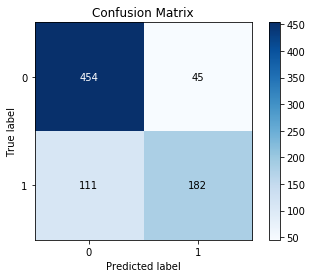

In [52]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_svm)

In [53]:
#tuning a random forest classifier
estimators = [5,10,15,20,25]
for e in estimators:
    rfc = RandomForestClassifier(n_estimators=e, random_state=42)
    rfc.fit(train_features, y_train)
    rfc_tfidf_test_score = rfc.score(test_features, y_test) 
    print('Test Accuracy:'+ str(e) + ' ' + str(rfc_tfidf_test_score))

Test Accuracy:5 0.8042929292929293
Test Accuracy:10 0.8194444444444444
Test Accuracy:15 0.8320707070707071
Test Accuracy:20 0.8257575757575758
Test Accuracy:25 0.8371212121212122


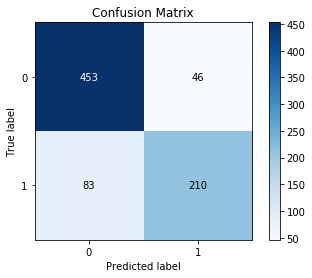

In [55]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rfc)

## 3.9 Manually Reviewing False Positives/Negatives

In [56]:
# joining the rfc prediction back to the original dataframe
descriptions_cycle_1.loc[indices_test,'rfc_pred_test'] = y_pred_rfc
descriptions_cycle_1.loc[indices_train,'rfc_pred_test'] = y_train
descriptions_cycle_1.loc[:,'rfc_pred_test'] = descriptions_cycle_1.loc[:,'rfc_pred_test'].astype(np.int64)
descriptions_cycle_1[descriptions_cycle_1.loc[:,'label'] == 0][descriptions_cycle_1.loc[:,'rfc_pred_test'] == 1].to_csv('false_positive.csv')  

In [62]:
# importing reviewed false positives dataframe =
reviewed_false_positive = pd.read_csv('false_positive.csv')

In [63]:
reviewed_false_positive.head()

,vid_id
0,5e6fe247-a52e-467b-acd7-240bd254f6e9
1,5954f1dd-9ff2-42df-bcfe-07621da2b1db
2,5e6fe233-a02b-43ce-8ff2-3c9c0b36d979
3,5e62e70b-3558-455b-bd8f-7c6cb22ca6e2
4,5e62e70c-2902-492d-bcd2-172705102471


In [64]:
# joining the wrong false positives to the dataframe to get a more comprehensive set of matches
descriptions_cycle_1.loc[:,'final_label'] = descriptions_cycle_1.loc[:,'label'] + descriptions_cycle_1.loc[:,'vid_id'].apply(lambda x: 1 if x in list(reviewed_false_positive.vid_id) else 0).astype(np.int64)

In [65]:
descriptions_cycle_1.groupby('final_label').count()

,vid_id,vid_title,tag,vid_des,post_date,owner_id,com_num,like_num,dis_num,text,title_des_text,text_tokens,title_des_tokens,first_tag_ghostbuster,first_tag_ghostbuster_title_des,tag_cluster,vid_title_cluster,vid_des_cluster,label,rfc_pred_test
final_label,,,,,,,,,,,,,,,,,,,,
0,1530,1530,1530,1530,1530,1530,1484,1473,1473,1530,1530,1530,1530,1530,1530,1530,1530,1530,1530,1530
1,867,867,867,867,867,867,763,762,762,867,867,867,867,867,867,867,867,867,867,867


## 3.10 Looking into Video Matches

In [66]:
# creating the final video match dataframe
descriptions_final = descriptions_cycle_1[descriptions_cycle_1.loc[:,'final_label']==1]
descriptions_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 46 to 38503
Data columns (total 21 columns):
vid_id                             867 non-null object
vid_title                          867 non-null object
tag                                867 non-null object
vid_des                            867 non-null object
post_date                          867 non-null datetime64[ns, UTC]
owner_id                           867 non-null object
com_num                            763 non-null float64
like_num                           762 non-null float64
dis_num                            762 non-null float64
text                               867 non-null object
title_des_text                     867 non-null object
text_tokens                        867 non-null object
title_des_tokens                   867 non-null object
first_tag_ghostbuster              867 non-null float64
first_tag_ghostbuster_title_des    867 non-null float64
tag_cluster                        867 non-null i

In [67]:
descriptions_final.to_csv('descriptions_final')

In [428]:
# checking unique count of each column
print(descriptions_final.nunique())
print(descriptions_final.groupby('owner_id').nunique()[['vid_id']].sort_values(by=['vid_id'], ascending=False).head())

Unnamed: 0                         867
vid_id                             867
vid_title                          839
tag                                711
vid_des                            864
post_date                          867
owner_id                           684
com_num                            275
like_num                           383
dis_num                            194
text                               867
title_des_text                     867
text_tokens                        867
title_des_tokens                   867
first_tag_ghostbuster              3  
first_tag_ghostbuster_title_des    4  
tag_cluster                        4  
vid_title_cluster                  8  
vid_des_cluster                    5  
label                              2  
rfc_pred_test                      2  
final_label                        1  
year                               14 
dtype: int64
                                      vid_id
owner_id                                    


In [429]:
# most productive content creator's content
descriptions_final[descriptions_final['owner_id'] == '5beb1d86-e940-4e7e-b9f9-fc46229203b1'][['vid_title','like_num','com_num','dis_num','post_date']]

,vid_title,like_num,com_num,dis_num,post_date
100,Jennifer Lawrence & Amy Schumer best friends! Ghostbusters Remake vs Remake - Beyond The Trailer,302.0,34.0,16.0,2015-07-31 14:08:02+00:00
469,"Ghostbusters 2016 First Look, On-Set Photos - Review aka Reaction - Beyond The Trailer",764.0,623.0,720.0,2015-06-22 17:01:26+00:00
560,Ghostbusters 2016 Movie Review,2088.0,1189.0,2721.0,2016-07-10 16:45:15+00:00
645,"Box Office for The Secret Life of Pets, Ghostbusters 2016 Reviews, Sultan",940.0,480.0,139.0,2016-07-11 19:51:20+00:00
649,Ghostbusters 2016 SPOILERS Movie Review,1153.0,611.0,1111.0,2016-07-10 18:02:24+00:00
665,Top Ten Worst Movies of 2016,2110.0,1117.0,306.0,2017-01-05 17:03:05+00:00
790,Ghostbusters 2016 Trailer 2 REACTION,2753.0,2300.0,1052.0,2016-05-18 14:38:27+00:00
816,Ghostbusters Afterlife Trailer REACTION,5317.0,1218.0,615.0,2019-12-09 14:57:46+00:00


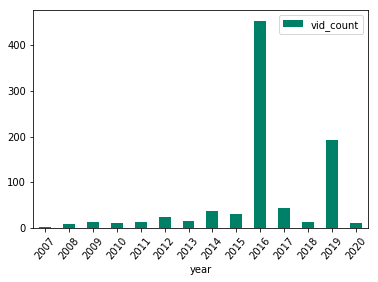

In [430]:
# video count by year
descriptions_final['year'] = pd.DatetimeIndex(descriptions_final['post_date']).year
descriptions_final.groupby('year').nunique()['vid_id'].reset_index().rename(columns={'vid_id':'vid_count'}).plot.bar(x='year', y='vid_count',colormap='summer', rot=50)

# 4. Looking For Ghostbusters Related Comments

## 4.1 Cleaning and Filtering Comments Dataset

In [68]:
comments.head()

,Comment ID,Video ID,Comment,age,gender,ethnicity
0,5d49a4e8-0632-4132-b1f2-163615d73515,5d49a262-27e5-4e39-831f-ad1b59e13bf9,Absolute human,"{'value': 'young', 'score': 0.5281285668295823}","{'value': 'male', 'score': 1.0}","{'value': 'white', 'score': 1.0}"
1,5d49a4e9-6397-4bdb-b63d-d5a963881ac8,5d49a261-5474-43a8-8cb5-18d51f0d7398,good job guys,"{'value': 'young', 'score': 0.7313715408212422}","{'value': 'male', 'score': 1.0}","{'value': 'white', 'score': 1.0}"
2,5d49a4e9-485e-4761-8acf-7e5128e3f9ae,5d49a261-5474-43a8-8cb5-18d51f0d7398,"Yikes <a href=""https://chrome.google.com/webst...","{'value': 'young', 'score': 0.5}","{'value': 'unknown', 'score': 1.0}","{'value': 'asian', 'score': 1.0}"
3,5d49a4e9-ae09-4be3-a181-487583f22cf0,5d49a261-5474-43a8-8cb5-18d51f0d7398,I first stumbled across Coheed back during fre...,"{'value': 'mid', 'score': 0.5}","{'value': 'unknown', 'score': 1.0}","{'value': 'african_black', 'score': 0.98591950..."
4,5d49a4e9-d129-420e-b046-895fc962ec20,5d49a261-5474-43a8-8cb5-18d51f0d7398,saw them last year and it was one of the best ...,"{'value': 'young', 'score': 0.886839130276653}","{'value': 'male', 'score': 1.0}","{'value': 'unknown', 'score': 1.0}"


In [69]:
# changing comments column names
comments = comments.rename({'Video ID': 'vid_id', 
                            'Comment ID': 'com_id',
                            'Comment':'com'}, axis=1)

In [70]:
# removing all comments from videos that are not related to ghostbusters
%%time
comments['relevance'] = comments['vid_id'].apply(lambda x: 1 if x in list(descriptions_final.vid_id) else 0)

CPU times: user 37.1 s, sys: 8.71 ms, total: 37.1 s
Wall time: 37.1 s


In [71]:
relevant_comment = comments[comments['relevance'] == 1]

In [72]:
relevant_comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72447 entries, 14 to 461778
Data columns (total 7 columns):
com_id       72447 non-null object
vid_id       72447 non-null object
com          72446 non-null object
age          72447 non-null object
gender       72447 non-null object
ethnicity    72447 non-null object
relevance    72447 non-null int64
dtypes: int64(1), object(6)
memory usage: 4.4+ MB


In [8]:
# exporting relevant comment to csv dataset for the next working session
relevant_comment.to_csv('relevant_comment.csv')
relevant_comment = pd.read_csv('relevant_comment.csv')

## 4.2 Preprocessing Comments

In [434]:
# Tailoring normalizing function for comments 
def normalize_comment(s):
    s = str(s)
    stripped = re.sub('http://\S+|https://\S+', '', s)
    stripped = re.sub(r'[^a-zA-z\s]' , '', stripped)
    stripped = re.sub('\n','',stripped)
    stripped = re.sub('_','',stripped)
    stripped = re.sub('-','',stripped)
    stripped = stripped.lower()
    stripped = stripped.strip("[]")
    stripped = expand_contractions(stripped)
    return stripped

In [10]:
# Clustering comments to get an intial understanding of the corpus
%%time
output_cols = []
n_clusters = 8
n_pca_groups = 50

print("1.Reading Corpus")
corpus = list(relevant_comment.loc[:,'com'].apply(lambda x: normalize_comment(x)))
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, 
                                 preprocessor=stemmer.stem, 
                                 ngram_range=(1,3),
                                 max_features = 500)
print("2.Fit Transform TF-IDF")
X = vectorizer.fit_transform(corpus)
tfidf_cols = list(vectorizer.get_feature_names())
print("3.Create Dataframe")
tfidf_df = pd.DataFrame(data=X.todense(), columns=vectorizer.get_feature_names())
    
#pca = PCA(n_components=n_pca_groups)
#print("4.Fit Transform PCA")
#pca_df = pca.fit_transform(tfidf_df)
#pca_df = pd.DataFrame(data=pca_df)
    
print("5.Fit Transform KMeans")
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(tfidf_df)
pred = kmeans.predict(tfidf_df)
cluster_col_name = '{}_cluster'.format('com')

print("6.Write Data")
tfidf_df[cluster_col_name] = pred
relevant_comment[cluster_col_name] = pred
    
output_cols.append(cluster_col_name)
print("7.Print Summary")
print(cluster_col_name)
for x in np.unique(pred):
    temp = tfidf_df[tfidf_df[cluster_col_name]==x][tfidf_cols].sum()
    temp = temp.sort_values(ascending=False)
    print('Cluster {x}: {n} N'.format(x=x, n='{:,}'.format(np.sum(relevant_comment[cluster_col_name]==x))))
    print(temp[:20])
    print()

1.Reading Corpus
2.Fit Transform TF-IDF
3.Create Dataframe
5.Fit Transform KMeans
6.Write Data
7.Print Summary
com_cluster
Cluster 0: 1,123 N
thought         444.980559
movie            51.398749
good             40.732462
trailer          33.699081
one              29.323147
really           27.829861
first            26.932314
didnt            26.367561
ghostbusters     26.342526
br               26.104384
actually         25.182100
im               25.068261
bad              24.596593
saw              23.911779
film             23.734491
funny            23.619030
going            22.504623
looked           21.546366
dont             19.444792
see              19.407224
dtype: float64

Cluster 1: 1 N
really                   0.371341
looking                  0.342338
roles                    0.199505
racist                   0.194002
top                      0.191252
job                      0.183465
comes                    0.182525
bill murray              0.180151
mccarthy       

In [433]:
# Updating stop word list to comment content
stop_words_2 = set(stopwords.words('english'))
extra_words_2 = ['gtgtgtgtghostbust','ive','gt','lt','yay','gtgtgtgtghostbusters','gtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgtgt','fuck','fucking','first','even','xd','im','br','href','lol','one','href','still','isnt','dont',"[","]",'copyright','1','2','3','4','5','us','tumblr','patreon','twitter', 'facebook', 'creepypasta', 'instagram', 'like', 'video','subscribe', 'please', 'channel', 'comment', 'forget',  'check',   'thanks',  'guys',    'enjoy',   'share',   'follow', 'plea', 'watching', "'", "'d", "'ll", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'r', 'sha', 'themselv', 'thi', 'v', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv','becau', 'guy', 'pleas', 'subscrib', 'thank', 'watch']
for w in extra_words_2:
    stop_words_2.add(w)

In [11]:
# Preprocessing comments
%%time
relevant_comment['comment_tokens'] = relevant_comment.loc[:,'com'].apply(lambda x: preprocess(x))

CPU times: user 25.5 s, sys: 45.4 ms, total: 25.6 s
Wall time: 25.6 s


## 4.3 Creating a Comment Matcher

In [27]:
# Comment matcher similar to Video's with more relevant words extracted from the clustering results
def ghost_buster_related_comment(list):
    label = 0
    if process.extractOne("ghostbuster", list, score_cutoff = 91) != None:
        label += 1
    important_words = ['plot','think','direct','movie','movies','film','films','afterlife','review','trailer']
    for w in important_words:
        if process.extractOne(w, list, score_cutoff = 100) != None:
            label += 0.25
    punished_words = {'halloween':80,'dimensions':95,'paranormal':90,'haunted':92,'game':89,'pokemon':100,'toy':86,'ecto1':100,'ecto':100,'lego':85,'wellness':85,'comic':100,'book':100}
    for key, value in punished_words.items():
        if process.extractOne(key, list, score_cutoff = value) != None:
            label -= 5
    return label

In [28]:
# matching comments against the matcher
%%time
relevant_comment['related_tag'] =  relevant_comment.loc[:,'comment_tokens'].apply(lambda x: ghost_buster_related_comment(x))

CPU times: user 10min 42s, sys: 88.8 ms, total: 10min 42s
Wall time: 10min 42s


In [43]:
# Extracting comments related to Ghostbusters
relevant_comment = relevant_comment[relevant_comment.related_tag >= 1]

## 4.3 Euclidean Similarity of Comments to Video Corpus

In [89]:
# making a corpus of video title and description texts
corpus = set(list(result.loc[:,'title_des_text'].apply(lambda x: normalize(x))))
one_corpus = ' '.join(corpus)

# initiating a vectorizer
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, 
                                 preprocessor=stemmer.stem, 
                                 ngram_range=(1,2),
                                 max_features = 1000)
tfidf_vector = vectorizer.fit_transform([one_corpus])

#creating the euclidean similarity function
def euclidean_similarity(tfidf_vector,x):
    nom = normalize(x)
    x_vec = vectorizer.transform([nom])
    sim = euclidean_distances(tfidf_vector,x_vec)
    sim_score = sim.sum()
    return sim_score

In [55]:
# finding euclidean similarity score
relevant_comment['sim_score'] = relevant_comment['com'].apply(lambda x: euclidean_similarity(tfidf_vector,x))

In [68]:
print(relevant_comment.vid_id.nunique())
print(relevant_comment.shape)

180
(6694, 11)


In [432]:
# finding passionate ghostbusters comments
ghostbuster_comment = relevant_comment[relevant_comment['sim_score'] < 1]
print(ghostbuster_comment.vid_id.nunique())
print(ghostbuster_comment.shape)

101
(826, 15)


In [435]:
# reclustering for a better idea of passionate comments
%%time
output_cols = []
n_clusters = 10
n_pca_groups = 50

print("1.Reading Corpus")
corpus = list(ghostbuster_comment.loc[:,'com'].apply(lambda x: normalize_comment(x)))
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words_2, 
                                 preprocessor=stemmer.stem, 
                                 ngram_range=(1,1),
                                 max_features = 1000)
print("2.Fit Transform TF-IDF")
X = vectorizer.fit_transform(corpus)
tfidf_cols = list(vectorizer.get_feature_names())
print("3.Create Dataframe")
tfidf_df = pd.DataFrame(data=X.todense(), columns=vectorizer.get_feature_names())
    
pca = PCA(n_components=n_pca_groups)
print("4.Fit Transform PCA")
pca_df = pca.fit_transform(tfidf_df)
pca_df = pd.DataFrame(data=pca_df)
    
print("5.Fit Transform KMeans")
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_df)
pred = kmeans.predict(pca_df)
cluster_col_name = '{}_cluster'.format('com')

print("6.Write Data")
tfidf_df[cluster_col_name] = pred
ghostbuster_comment[cluster_col_name] = pred
    
output_cols.append(cluster_col_name)
print("7.Print Summary")
print(cluster_col_name)
for x in np.unique(pred):
    temp = tfidf_df[tfidf_df[cluster_col_name]==x][tfidf_cols].sum()
    temp = temp.sort_values(ascending=False)
    print('Cluster {x}: {n} N'.format(x=x, n='{:,}'.format(np.sum(ghostbuster_comment[cluster_col_name]==x))))
    print(temp[:10])
    print()

1.Reading Corpus
2.Fit Transform TF-IDF
3.Create Dataframe
4.Fit Transform PCA
5.Fit Transform KMeans
6.Write Data
7.Print Summary
com_cluster
Cluster 0: 44 N
afterlife       13.855345
afterlif        8.259002 
ghostbusters    7.807601 
got             2.995044 
sounds          1.269544 
ghostbust       0.981266 
wonder          0.964026 
origin          0.937526 
remake          0.930966 
trail           0.929844 
dtype: float64

Cluster 1: 90 N
ghostbusters    89.337147
ghostbust       0.717671 
babe            0.643022 
way             0.419455 
zuul            0.000000 
franchise       0.000000 
future          0.000000 
futur           0.000000 
funny           0.000000 
funnier         0.000000 
dtype: float64

Cluster 2: 8 N
suck            5.283795
ghostbusters    0.957109
fact            0.701377
get             0.676436
shoo            0.629220
bett            0.594931
troll           0.592902
cast            0.543703
billl           0.515700
expected        0.488540
dtype: f

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 4.4 Creating a Lexicon Based Sentiment Analyzer 

In [81]:
# try VADER lexicon 
def analyze_sentiment_vader_lexicon(com):
    n_com = normalize(com)
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(n_com)
    score = scores['compound']
    final_score = 'positive' if score > 0.5 else 'negative'
    return final_score

In [219]:
# computing sentiment score
relevant_comment['sentiment_score'] = relevant_comment['com'].apply(lambda x: analyze_sentiment_vader_lexicon(x))
relevant_comment[['com','sentiment_score']].head(5)

,com,sentiment_score
23,why did they call thr movie just ghostbusters again i mean there are ghostbusters then ghostbusters 2 and now ghostbuster no 3 nothing why? i find the old classic better,negative
25,the girls ghostbusters didnt fight the stay puft marshmellow man,negative
38,Ghostbuster Bike?........ Really?...........Pass,negative
39,"The new Scooby Doo movie looks great.... Oh wait this is a Michael Bay Ghostbusters film made for kids, because the original Ghostbusters was for kids right?<br />Was hoping to not see another cash grab",positive
43,but seiously I am not a sexist but I hate ghostbusterts 2016,positive


In [87]:
# Looks like lexicon based Sentiment Analyzer doesn't work so well in this case
relevant_comment[['com','sentiment_score']].loc[43,'com']

'but seiously I am not a sexist but I hate ghostbusterts 2016'

# 5. Visualizations

In [200]:
# Creating a video title and description corpus
video_corpus = preprocess(one_corpus)

In [156]:
# Vectorizing the corpus
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(
                     tokenizer=word_tokenize, 
                     stop_words=stop_words_2, 
                     preprocessor=stemmer.stem, 
                     ngram_range=(1,2)
                     ) 
cv_features = cv.fit_transform(video_corpus)
cv_features.shape

(10726, 2735)

In [157]:
vocabulary = np.array(cv.get_feature_names()) 
print('Total Vocabulary Size:', len(vocabulary))

Total Vocabulary Size: 2735


In [166]:
# trying LDA topic modeling
%%time
lda_model = LatentDirichletAllocation(n_components = 20, 
                                      max_iter=500, 
                                      max_doc_update_iter=50, 
                                      learning_method='online', 
                                      batch_size=1740, 
                                      learning_offset=50., 
                                      random_state=42, 
                                      n_jobs=16) 
document_topics = lda_model.fit_transform(cv_features)

CPU times: user 45.6 s, sys: 13.2 s, total: 58.8 s
Wall time: 5min 48s


In [170]:
# Inserting topic terms to a dataframe
topic_terms = lda_model.components_
top_terms = 10
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms] 
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics,
columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1,20+1)])

In [171]:
topics_df

,Terms per Topic
Topic1,"support, social, merch, footag, finn, behind, research, pro, light, michael"
Topic2,"paul, ghostbustersafterlif, want, hd, know, ever, begin, trailerreact, mom, becom"
Topic3,"review, film, product, cast, today, town, male, gain, affili, locat"
Topic4,"ghostbust, ross, let, lesli, grandfath, j, wiig, allow, gear, snapchat"
Topic5,"offici, direct, jone, help, kenan, assist, pictur, mckenna, breakdown, canon"
Topic6,"clip, look, critic, voic, call, much, thought, shoutout, entir, stay"
Topic7,"movi, bill, visit, aykroyd, connect, titl, someth, ghostbustersafterlifetrail, mike, latest"
Topic8,"music, bolling, episod, favorit, day, great, boon, univers, theme, everyon"
Topic9,"pencilm, link, give, youtub, singl, produc, dan, kid, melissa, camera"
Topic10,"get, reboot, fan, murray, show, feminist, go, franchis, mail, store"


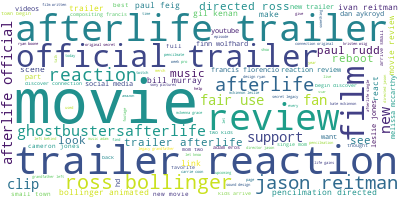

In [203]:
# making word cloud for video title and description
video_corpus_trimmed = [i for i in video_corpus if i not in ['ghostbusters','ghostbuster']]
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(' '.join(video_corpus_trimmed))
wordcloud.to_image()

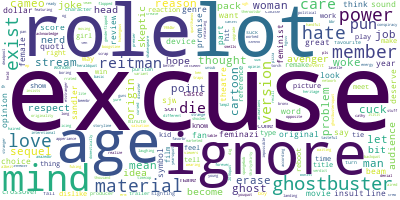

In [414]:
# making word cloud for comments
comment_corpus = list(ghostbuster_comment.loc[:,'com'].apply(lambda x: preprocess(x)))
comment_corpus = set(itertools.chain(*comment_corpus))
comment_corpus_trimmed = [i for i in comment_corpus if i not in ['ghostbusters','ghostbuster','cuck','shit','lot']]
wordcloud.generate(' '.join(comment_corpus))
wordcloud.to_image()

In [425]:
# looking into feminist related videos/comments
ghostbuster_comment[ghostbuster_comment['com_cluster'] == 4]

,Unnamed: 0,com_id,vid_id,com,age,gender,ethnicity,relevance,comment_tokens,related_tag,sim_score,sentiment_score,age_score,gender_score,ethnicity_score,com_cluster
3599,49573,5e701132-fa0a-4afc-a01a-d4a9bc5f6482,5e6fe246-2f0d-4ca5-838c-b280b03a3c74,I like all of the Ghostbusters movies,mid,female,white,1,"[ghostbusters, movies]",1.25,0.789207,negative,0.777181,1.000000,1.000000,4
3652,49690,5e6fe7a2-9fab-46eb-af62-02f86a1509e1,5e6fe22f-ed74-4b39-9280-8b6c1b2dd3cb,This is a real Ghostbusters movie that we fans of the original should have gotten in 2016. F that 2016 Ghostbusters movie!,mid,unknown,unknown,1,"[real, ghostbusters, movie, fans, original, gotten, f, ghostbusters, movie]",1.25,0.955170,negative,0.500000,1.000000,1.000000,4
7464,68928,5e70a704-a278-4514-a467-483d25a1f691,5e6fe297-7eb1-4563-889f-2529d9798f50,Me too!!! AND OF COURSE THE GHOSTBUSTERS MOVIE!!,mid,unknown,white,1,"[course, ghostbusters, movie]",1.25,0.789207,negative,0.500000,1.000000,1.000000,4
12991,87442,5e7128c3-3aa3-4561-8e61-5d10f3118654,5e6fe265-824d-46b3-ac20-f7faddd38b04,Ghostbusters 1 is a 10/10. Ghostbusters 2 is a 8/10. Ghostbusters 2 gets way to much hate. It&#39;s a cool movie.,mid,male,white,1,"[ghostbusters, ghostbusters, ghostbusters, gets, way, much, hate, cool, movie]",1.25,0.962303,negative,0.675446,1.000000,0.736274,4
15507,129438,5e6334ff-9f9f-4570-9e91-90f973ef0a82,5e62e70d-25a1-4e1e-960b-3f7233013b02,What a shocker: a woman doesn’t like the replacement movie to an awful feminine excuse for a ghostbusters movie,mid,unknown,unknown,1,"[shocker, woman, doesnt, replacement, movie, awful, feminine, excuse, ghostbusters, movie]",1.25,0.998942,negative,0.500000,1.000000,1.000000,4
16407,134934,5e63a7fa-c2e9-49f6-aa23-8b9efeb19241,5e0a3a7d-6b56-4df4-a6e2-369de55dc874,THIS IS HOW YOU DO A GHOSTBUSTERS MOVIE!!!!!!!IAM EXCITED GHOSTBUSTERS MOVIE !!!!!!!!!! A REAL GHOSTBUTERS MOVIE!!!!!,mid,male,white,1,"[ghostbusters, movieiam, excited, ghostbusters, movie, real, ghostbuters, movie]",1.25,0.928597,negative,0.500000,1.000000,1.000000,4
16762,137278,5e62e804-ec33-448c-a316-780c83136bfe,5e62e70e-082d-4961-9c68-9a81d6fc3a76,Ghostbusters as a horror movie.,mid,unknown,unknown,1,"[ghostbusters, horror, movie]",1.25,0.789207,negative,0.500000,1.000000,1.000000,4
19195,145852,5e70affc-8fc1-4e5d-9f54-7bf73762295b,5e6fe246-2f0d-4ca5-838c-b280b03a3c74,This movie destroyed ghostbusters Franchising....<br /><br />yes...i saw the movie....a bad movie...,mid,unknown,white,1,"[movie, destroyed, ghostbusters, franchisingbr, br, yesi, saw, moviea, bad, movie]",1.25,0.998282,negative,0.500000,1.000000,1.000000,4
19489,146815,5e7096d9-8c87-4f68-b85d-48b4ec413552,5e6fe280-0976-4c49-a7c8-4b2256cb4b75,@Sloth Nope. I truly like the looks of this as a movie. It seriously is just a regular Ghostbusters movie.,mid,unknown,unknown,1,"[sloth, nope, truly, looks, movie, seriously, regular, ghostbusters, movie]",1.25,0.996960,negative,0.500000,1.000000,1.000000,4
20656,150786,5e70acf3-86f6-4b77-8e29-86f726364811,5e6fe298-2247-46a7-94dd-60512908814e,"They should reboot Ghostbusters again next year, and all ghostbusters should be played by Deadpool.<br /><br />Maybe Deadpool should play all roles in all movies.",mid,male,african_black,1,"[reboot, ghostbusters, next, year, ghostbusters, played, deadpoolbr, br, maybe, deadpool, play, roles, movies]",1.25,0.987591,positive,0.500000,0.929263,0.982551,4


In [421]:
ghostbuster_comment[ghostbuster_comment['com_id'] == '5e6334ff-9f9f-4570-9e91-90f973ef0a82']['com']

15507    What a shocker: a woman doesn’t like the replacement movie to an awful feminine excuse for a ghostbusters movie
Name: com, dtype: object

In [427]:
ghostbuster_comment[ghostbuster_comment['com_id'] == '5e7127f0-1221-46c4-a1e2-ff757113c7e5']['com']

70235    Wow, this trailer was just... blah. Nothing special at all. Doesn&#39;t make me excited for a new Ghostbusters let alone an all female Ghostbusters movie.
Name: com, dtype: object

# 6. Passionate Comment/Audience Classification

## 6.1 Loading Dataset and Cleaning Numeric Columns

In [216]:
# Loading Data
relevant_comment_initial = pd.read_csv('relevant_comment.csv')

In [217]:
relevant_comment_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72447 entries, 0 to 72446
Data columns (total 8 columns):
Unnamed: 0    72447 non-null int64
com_id        72447 non-null object
vid_id        72447 non-null object
com           72446 non-null object
age           72447 non-null object
gender        72447 non-null object
ethnicity     72447 non-null object
relevance     72447 non-null int64
dtypes: int64(2), object(6)
memory usage: 4.4+ MB


In [220]:
# Getting demographic features and cleaning people with < 0.5 probability score
demog = ['age','gender','ethnicity']
for i in demog:
    score_col_name = '{}_score'.format(i)
    relevant_comment_initial[score_col_name] = relevant_comment_initial[i].apply(lambda x: ast.literal_eval(x)['score'])
    relevant_comment_initial[i] = relevant_comment_initial[i].apply(lambda x: ast.literal_eval(x)['value'])  

In [222]:
relevant_comment_initial = relevant_comment_initial[relevant_comment_initial['age_score'] >= 0.5][relevant_comment_initial['gender_score'] >= 0.5][relevant_comment_initial['ethnicity_score'] >= 0.5]


In [295]:
# Getting popularity features from the descriptions_final dataframe. Popularity features = numbers of comments, likes, and dislikes
descriptions_final = pd.read_csv('descriptions_final')
relevant_comment_initial = pd.merge(relevant_comment_initial, descriptions_final[['vid_id','com_num','like_num','dis_num']],on='vid_id',how='left')

In [297]:
# Cleaning and removing wrong records on popularity features
float_col = ['com_num','like_num','dis_num']
for col in float_col:
    relevant_comment_initial[col] = relevant_comment_initial[col].astype(np.int64)
    
relevant_comment_initial = relevant_comment_initial[relevant_comment_initial['com_num'] >= 0][relevant_comment_initial['like_num'] >= 0][relevant_comment_initial['dis_num'] >= 0]

## 6.1 Checking for Class Imbalance and EDA

In [436]:
# Expectedly, very serious class imbalance
relevant_comment_initial['passionate_audience'] = relevant_comment_initial.loc[:,'com_id'].apply(lambda x: 1 if x in list(ghostbuster_comment.com_id) else 0)
relevant_comment_initial.groupby('passionate_audience').count()

,Unnamed: 0,com_id,vid_id,com,age,gender,ethnicity,relevance,age_score,gender_score,ethnicity_score,com_num,like_num,dis_num
passionate_audience,,,,,,,,,,,,,,
0,71470,71470,71470,71469,71470,71470,71470,71470,71470,71470,71470,71470,71470,71470
1,826,826,826,826,826,826,826,826,826,826,826,826,826,826


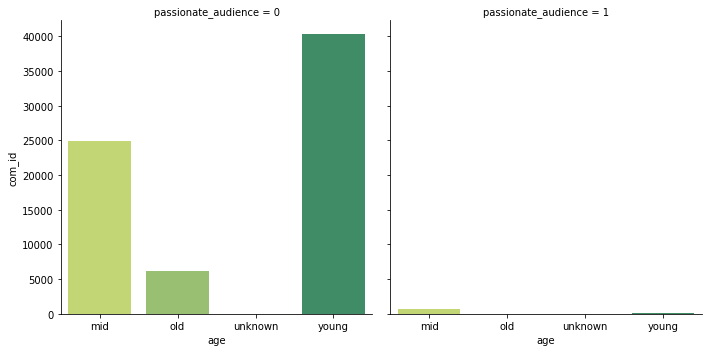

In [268]:
# factorplot for passionate audience and age
fg = sns.catplot(x='age', 
                 y='com_id',
                 col='passionate_audience', 
                 data=relevant_comment_initial.groupby(['passionate_audience','age']).nunique().drop(['age','passionate_audience'],axis=1).reset_index(), 
                 kind='bar',
                 palette='summer_r')

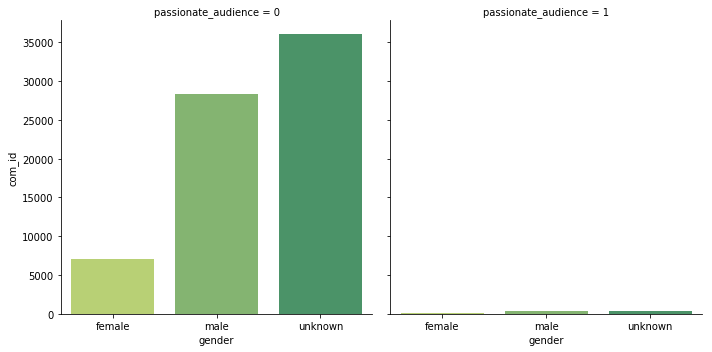

In [269]:
# factorplot for passionate audience and gender
fg = sns.catplot(x='gender', 
                 y='com_id',
                 col='passionate_audience', 
                 data=relevant_comment_initial.groupby(['passionate_audience','gender']).nunique().drop(['gender','passionate_audience'],axis=1).reset_index(), 
                 kind='bar',
                 palette='summer_r')

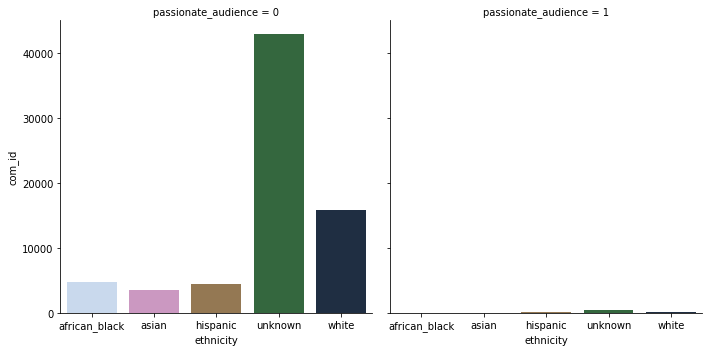

In [263]:
# factorplot for passionate audience and ethnicity
fg = sns.catplot(x='ethnicity', 
                 y='com_id',
                 col='passionate_audience', 
                 data=relevant_comment_initial.groupby(['passionate_audience','ethnicity']).nunique().drop(['ethnicity','passionate_audience'],axis=1).reset_index(), 
                 kind='bar',
                 palette='cubehelix_r')

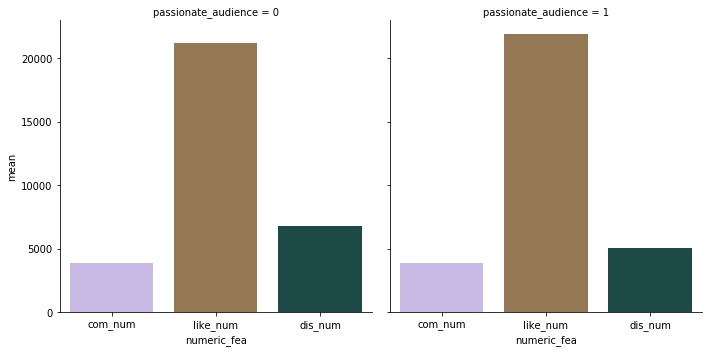

In [306]:
# factorplot for passionate audience and popularity features
fg = sns.catplot(x='numeric_fea', 
                 y='mean',
                 col='passionate_audience', 
                 data=relevant_comment_initial.groupby(['passionate_audience']).mean().reset_index()[['passionate_audience','com_num','like_num','dis_num']].melt(id_vars='passionate_audience',
                                                                                                                                            var_name='numeric_fea',
                                                                                                                                            value_name='mean'), 
                 kind='bar',
                 palette='cubehelix_r')

## 6.2 Preparing Dataframe for Classification Model Training

In [289]:
# label encoding categorical features
le = LabelEncoder()
relevant_comment_initial['age'] = le.fit_transform(relevant_comment_initial['age'])
relevant_comment_initial['gender'] = le.fit_transform(relevant_comment_initial['gender'])
relevant_comment_initial['ethnicity'] = le.fit_transform(relevant_comment_initial['ethnicity'])

In [307]:
# spliting X and y
X = relevant_comment_initial[['age','gender','ethnicity','com_num','like_num','dis_num']]
y = relevant_comment_initial[['passionate_audience']]

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

## 6.3 Training and Tuning Decision Tree Model

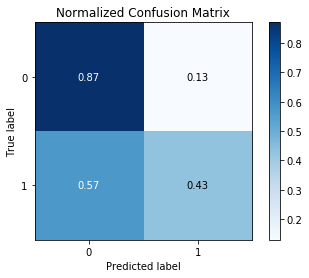

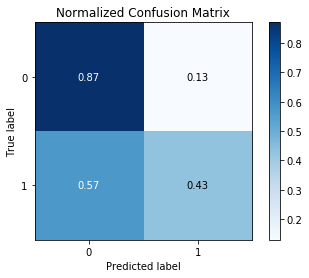

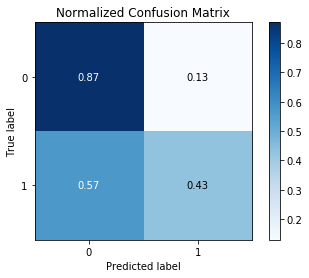

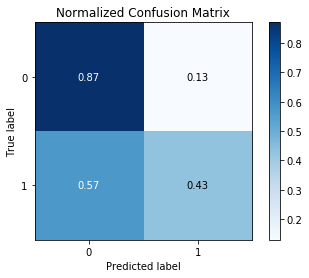

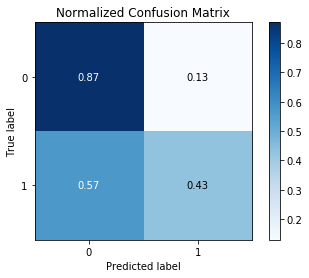

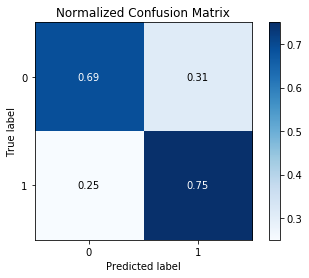

In [351]:
# Building and Tuning a simple tree to double check the prediction. Pre-pruning the tree by limiting max_depth 
# to avoid overfitting
# Increasing the class weight of passionate audience to help with class imbalance:
for i in range(50,56):
    dt = DecisionTreeClassifier(max_depth = 5, class_weight = {0:1,1:i})
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [352]:
tree.export_graphviz(dt, out_file='trees.dot', max_depth = 5, feature_names = X.columns)

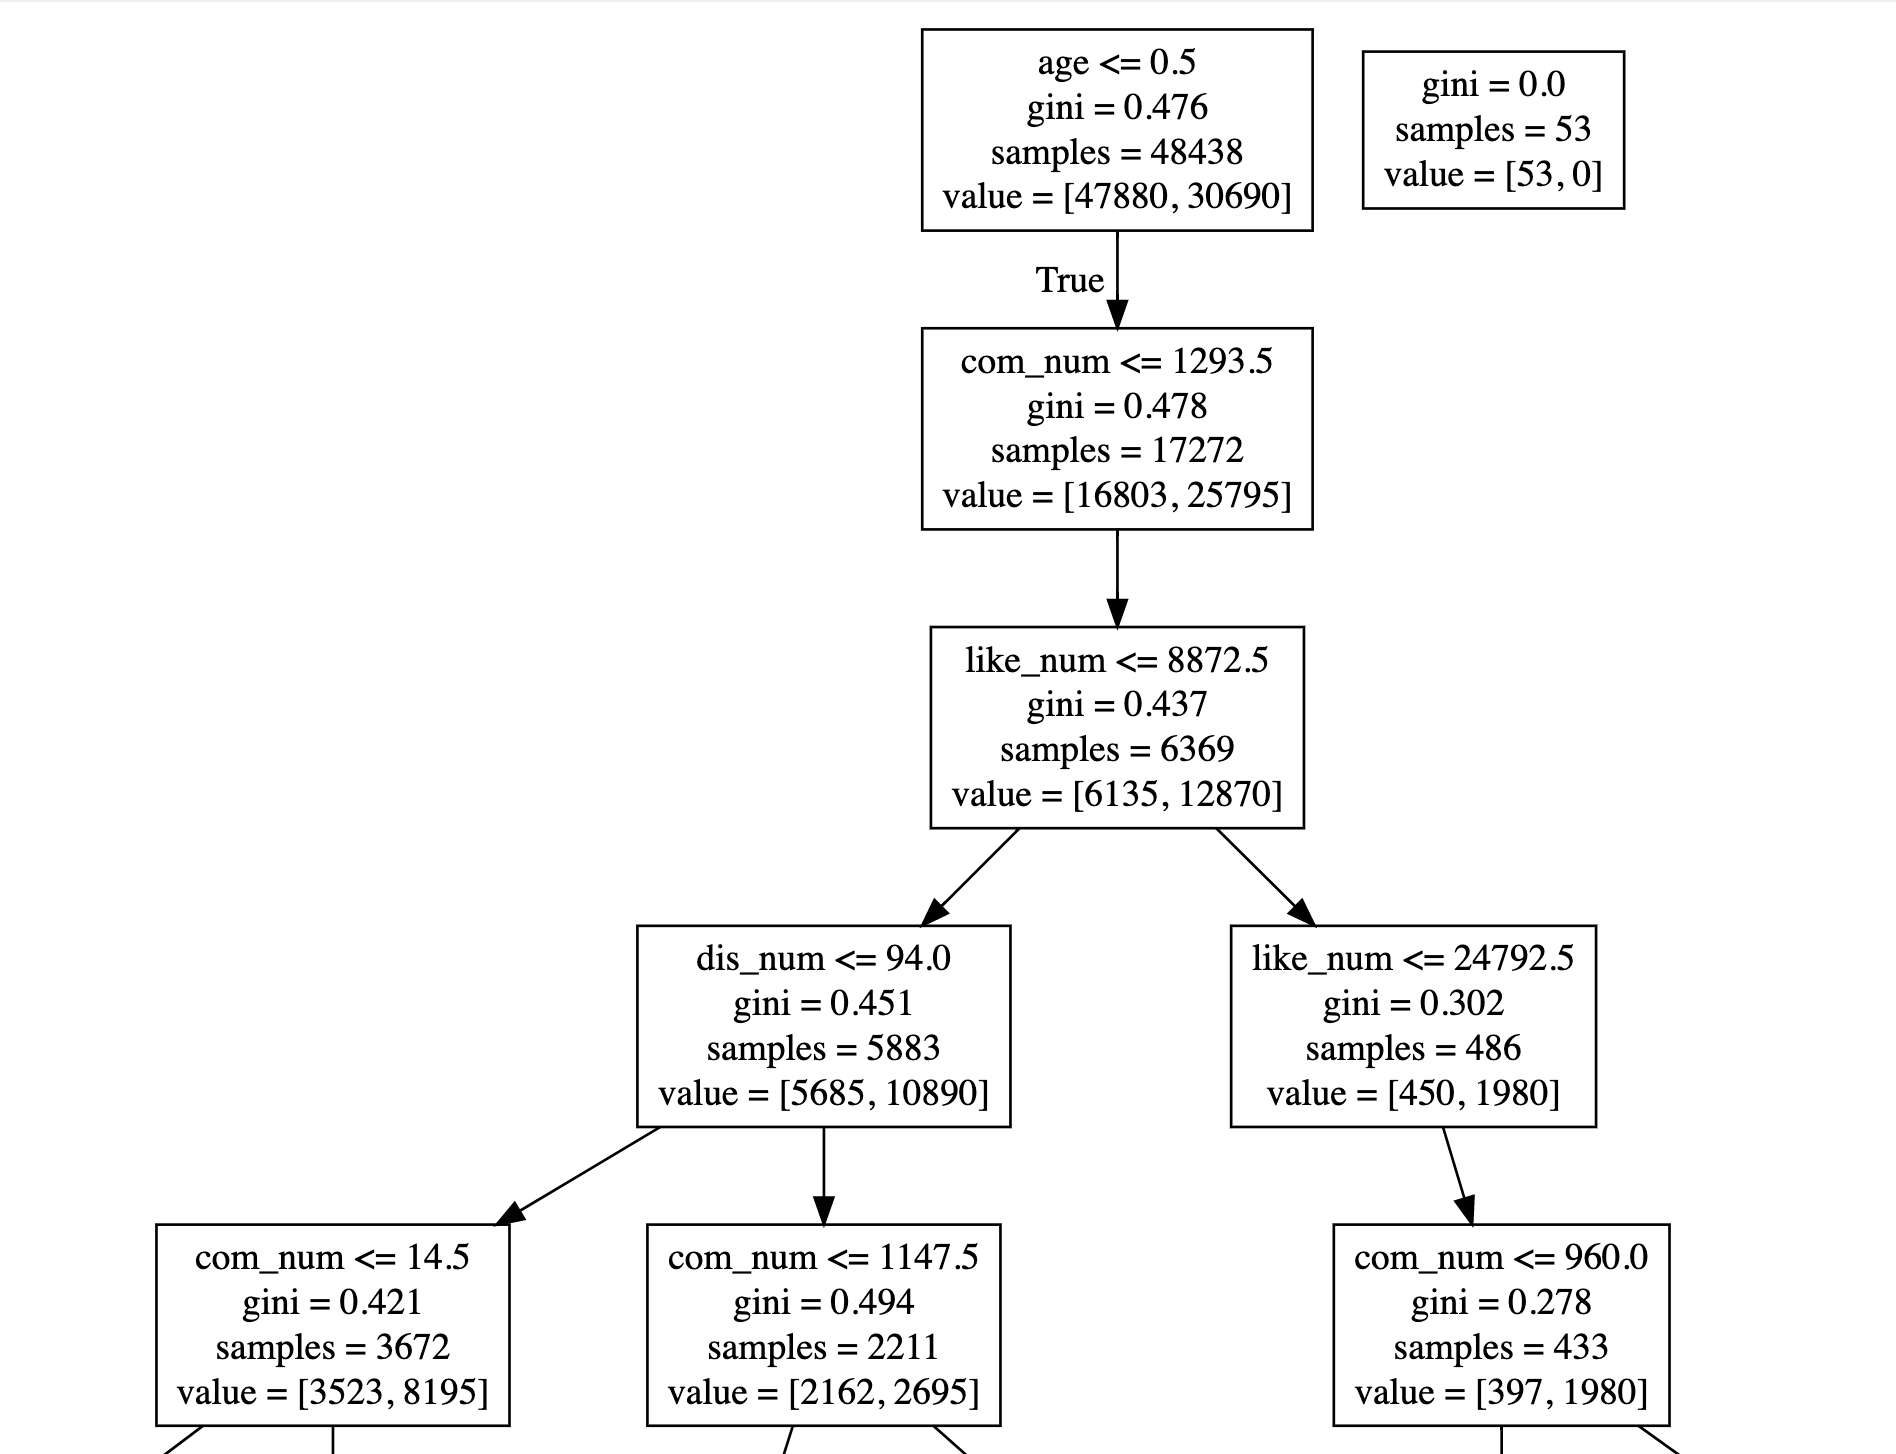

In [365]:
# Visualizing the tree
Image(filename='tree.png', width = 900, height = 400)